In [2]:
from hamiltonian import Hamiltonian

In [3]:
# 4 qubits
h2_jw_4 = Hamiltonian('H2_STO3g_4qubits', 'jw')
h2_parity_4 = Hamiltonian('H2_STO3g_4qubits', 'parity')
h2_bk_4 = Hamiltonian('H2_STO3g_4qubits', 'bk')

# 8 qubits
h2_jw = Hamiltonian('H2_6-31G_8qubits', 'jw')
h2_parity = Hamiltonian('H2_6-31G_8qubits', 'parity')
h2_bk = Hamiltonian('H2_6-31G_8qubits', 'bk')

# 12 qubits
lih_jw = Hamiltonian('LiH_STO3g_12qubits', 'jw')
lih_parity = Hamiltonian('LiH_STO3g_12qubits', 'parity')
lih_bk = Hamiltonian('LiH_STO3g_12qubits', 'bk')

In [7]:
hamiltonians = {"h2_jw_4": h2_jw_4,
                "h2_parity_4": h2_parity_4,
                "h2_bk_4": h2_bk_4,
                "h2_jw": h2_jw,
                "h2_parity": h2_parity,
                "h2_bk": h2_bk,
                "lih_jw": lih_jw,
                "lih_parity": lih_parity,
                "lih_bk": lih_bk}

The notebook paralellises the 6 computations associated with a given molecule:
- three encodings
- two values of beta (uniform and diagonal-optimal)

It then plots all three encodings with four different algorithms:
- ell_1
- ldf
- uniform pauli
- diagonal optimal pauli

In [3]:
beta_ALL = {}
variances_ALL = {}
algos_ALL = {}

In [4]:
%%time
# build two dictionaries containing the variances and the optimal betas for a fixed molecule
# the dictionary algos_ALL[molecule] is used for multithreading in the next cell

molecule = 'h2'
num_qubits = h2_jw.num_qubits
encodings = {'jw': h2_jw, 'parity': h2_parity, 'bk': h2_bk}

variances_ALL[molecule] = {}
beta_ALL[molecule] = {}
algos_ALL[molecule] = {}

for encoding, ham in encodings.items():
    pr = ham.pauli_rep
    energy, state = pr.ground()
    
    variances_ALL[molecule][encoding+'_ell_1'] = ham.pauli_rep.variance_ell_1(energy)
    
    algo = encoding+'_uniform'
    β = pr.local_dists_uniform()
    algos_ALL[molecule][algo] = [algo, pr, energy, state, β]  
    
    algo = encoding+'_optimal'
    β = pr.local_dists_optimal()
    algos_ALL[molecule][algo] = [algo, pr, energy, state, β]
    beta_ALL[molecule][algo] = β

/opt/anaconda3/envs/qiskit18/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:183: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


CPU times: user 1min 6s, sys: 8.04 s, total: 1min 14s
Wall time: 15.6 s


In [5]:
%%time
from multiprocessing import Pool
import multithread
if __name__ == '__main__':
    p = Pool(processes = 6)
    output = p.map(multithread.variance, algos_ALL[molecule].values())
    
    for algo, var in output:
        variances_ALL[molecule][algo] = var

CPU times: user 28.9 ms, sys: 26.1 ms, total: 54.9 ms
Wall time: 1.19 s


In [6]:
from matplotlib import pyplot as plt
import numpy as np

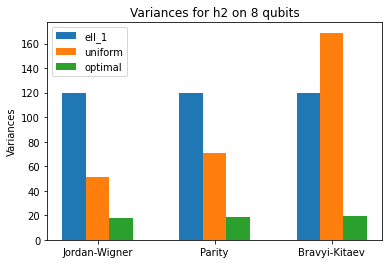

In [7]:
N = 3



variances = variances_ALL[molecule]
ell_1_variances = [variances['{}_ell_1'.format(encoding)] for encoding in encodings]
uniform_variances = [variances['{}_uniform'.format(encoding)] for encoding in encodings]
optimal_variances = [variances['{}_optimal'.format(encoding)] for encoding in encodings]

ind = np.arange(N) 
width = 0.2       
plt.bar(ind, ell_1_variances, width, label='ell_1')
plt.bar(ind + width, uniform_variances, width, label='uniform')
plt.bar(ind + 2*width, optimal_variances, width, label='optimal')

plt.ylabel('Variances')
plt.title('Variances for {0} on {1} qubits'.format(molecule, num_qubits))

plt.xticks(ind + width, ('Jordan-Wigner', 'Parity', 'Bravyi-Kitaev'))
plt.legend(loc='best')

file = '../images/variances_{0}_{1}qubits.png'.format(molecule, num_qubits)
plt.savefig(file, dpi=300)
plt.show()